# Autoencoder

In [59]:
!pip install seaborn

     |████████████████████████████████| 285 kB 1.5 MB/s 
You should consider upgrading via the '/home/lparolari/Projects/har/.venv/bin/python -m pip install --upgrade pip' command.


Set some global parameters

In [103]:
# Whether to rotate data in an orientation indiepndent manner.
# Default: True
USE_ORIENTATION_INDIPENDENT_TRANSFORMATION = False

# Whether to normalize data.
# Note: we usually do not normalize beacause the distance between points
# and reconstructed points gets reduced but the signal is not well represented
# Default: False
USE_NORMALIZATION = False

# Whether to center accelerometer data.
# Note: we tryed centering accelerometer data to check autoencoder behaviour with CNN center data.
# Default: False
USE_CENTERING_ACC = False

# Whether to low-pass filter data.
# Default: False
USE_LOW_PASS_FILTER = False

# Whether to use Bryan dataset as validation dataset.
# Default: False
USE_BRYAN_VALIDATION_DATASET = False

# Whether to use all positions (right, left, back, top, hand, pocket) from Bryan dataset.
# Default: Flase
USE_ALL_POSITION_BRYAN_DATASET = False

# Whether to use grid search for hyperparameters.
# Note: this task is resource intensive and could take a while. Keep it disabled for prototyping.
# Default: True
USE_GRID_SEARCH = True

# Whether to test some of the best models obtained by grid search.
# Default: True
USE_GRID_SEARCH_VALIDATION = True

In [104]:
def get_settings():
    """
    Return a string which encodes current global settings.
    Can be used as name of files.
    """
    oit = "_oit" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else ""
    norm = "_norm" if USE_NORMALIZATION else ""
    bryan = "_bryan" if USE_BRYAN_VALIDATION_DATASET else ""
    allpos = "_allpos" if USE_BRYAN_VALIDATION_DATASET and USE_ALL_POSITION_BRYAN_DATASET else ""
    return oit + norm + bryan + allpos

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [106]:
random.seed(42)
np.random.seed(42)

## Load dataset

In [107]:
def load_dataset(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None)
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label"])

    return data, labels


def load_dataset_position(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None)
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label", "position"])

    return data, labels

In [108]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [109]:
X_df_reference, y_df_reference = load_dataset(dataset_dir="./datasets/heterogeneity_f50_w2.5_o0.5")
X_df_reference_validation, y_df_reference_validation = load_dataset_position(dataset_dir="./datasets/bryan_f50_w2.5_o0.5")

In [110]:
print_stats(X_df_reference)
print_stats(y_df_reference)
print_stats(X_df_reference_validation)
print_stats(y_df_reference_validation)

Shape (46657, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (46657, 3)
Columns Index(['user', 'model', 'label'], dtype='object')
Shape (4790, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (4790, 4)
Columns Index(['user', 'model', 'label', 'position'], dtype='object')


## Preprocessing

In [111]:
def to_numpy(df):
    return df.loc[:].to_numpy()

In [112]:
def get_label(x):
    return x[..., 2]

In [113]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [114]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

In [115]:
def center(x):
    means = np.mean(x, axis=2)  # get mean for each dimension for each window
    means[:, 3:] = 0  # do not center gyroscope
    x = (x - means[:,:,np.newaxis])

In [116]:
from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [117]:
def plot_butter_lowpass_filter(cutoff, fs, order):
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

In [118]:
def get_X(df):
    """
    Return a numpy array with preprocessed X data
    """
    # 1. Back to numpy
    a = to_numpy(df)

    # 2. Restructure the array
    a = restructure(a)

    # Low-pass filter
    if USE_LOW_PASS_FILTER:
        for i in range(len(a)):
            window = a[i]
            lowpassed = [butter_lowpass_filter(window[j], cutoff=5, fs=50) for j in range(6)]
            a[i] = lowpassed

    # 3. Normalize
    if USE_NORMALIZATION:
        a = normalize(a)
        
    # 4. Orientation indipendent transformation
    if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
        a = orientation_independent_transformation(a)

    # 4. Center accelerometer data
    if USE_CENTERING_ACC:
        a = center(a)
    
    return a


def get_y(df):
    """
    Return a numpy array with labels
    """
    y = to_numpy(df)
    y = get_label(y)
    return y


def get_y_hot(df):
    """
    Return a numpy array with labels in one-hot encoding
    """
    return pd.get_dummies(df['label']).to_numpy()

### Training Set

In [119]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

Set up the low-pass filter

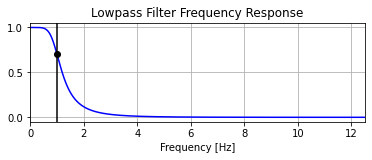

In [120]:
cutoff = 1  # desired cutoff frequency of the filter, Hz
fs = 25     # sample rate, Hz
order = 3

plot_butter_lowpass_filter(cutoff, fs, order)
plt.show()

Prepare the dataset with pandas
* split training and test set
* shuffle the dataset

In [121]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
if USE_BRYAN_VALIDATION_DATASET:
    but_last_user_indicies = ~(y_df['user'] == "z")
else:
    but_last_user_indicies = ~((y_df['user'] == "a") | (y_df['user'] == "b"))

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 36476
X_test_df = 10181
y_train_df = 36476
y_test_df = 10181


Preprocess dataset

In [122]:
# Preprocess and prepare training and test set
X_train, y_train = get_X(X_train_df), get_y(y_train_df)
X_test, y_test = get_X(X_test_df), get_y(y_test_df)

# Retrieve al
y_train_hot = get_y_hot(y_train_df)
y_test_hot = get_y_hot(y_test_df)

In [123]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36476, 6, 125)
(36476,)
(10181, 6, 125)
(10181,)


Show labels

In [124]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


Plot some samples

X[0]: stairsdown


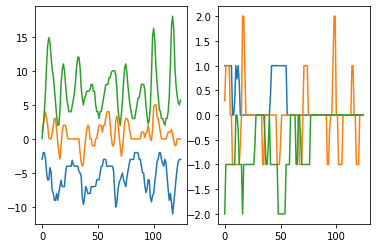

In [125]:
show_samples(X_train, y_train, n=1, is_random=False)

X[0]: walk


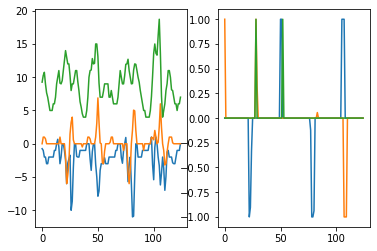

In [126]:
if (len(X_test) > 0):
    show_samples(X_test, y_test, n=1, is_random=False)
else:
    print("WARNING: there is no data in X_test. Are you using Bryan dataset as validation set?")

### Validation Set

Prepare the dataset

In [127]:
X_df, y_df = X_df_reference_validation.copy(), y_df_reference_validation.copy()

# Keep valid positions only
if USE_ALL_POSITION_BRYAN_DATASET:
    valid_positions_indicies = ~(y_df["position"] == "none") 
else:
    valid_positions_indicies = (y_df["position"] == "right") | (y_df["position"] == "left") | (y_df["position"] == "top") | (y_df["position"] == "back") | (y_df["position"] == "bottom")

# Filter out other data
X_df = X_df.loc[valid_positions_indicies]
y_df = y_df.loc[valid_positions_indicies]

# Shuffle data
X_df = X_df.sample(frac=1)
y_df = y_df.reindex(X_df.index)

Preprocess dataset

In [128]:
X_validation = get_X(X_df)
y_validation = get_y(y_df)
y_validation_hot = get_y_hot(y_df)

In [129]:
X_validation_df = X_df.copy()
y_validation_df = y_df.copy()

del X_df, y_df

In [130]:
print(X_validation.shape)
print(y_validation.shape)
print(y_validation_hot.shape)

(2349, 6, 125)
(2349,)
(2349, 5)


X[0]: no_activity


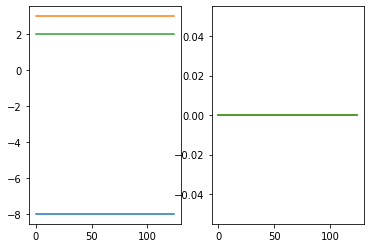

In [131]:
show_samples(X_validation, y_validation, n=1, is_random=False)

In [132]:
if USE_BRYAN_VALIDATION_DATASET:
    X_test = X_validation
    y_test = y_validation
    y_test_hot = y_validation_hot

X[0]: walk


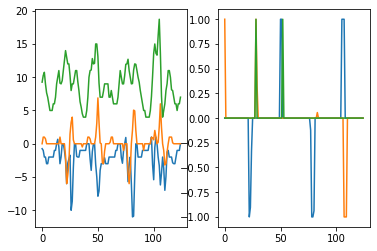

In [133]:
show_samples(X_test, y_test, n=1, is_random=False)

Check size

In [134]:
assert X_train.shape[0] == y_train.shape[0], f"Invalid shape for X_train and y_train: {X_train.shape} != {y_train.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

## Data Exploration

### Training Set

In [135]:
print("Users", y_train_df["user"].unique())
print("Models", y_train_df["model"].unique())
print("Classes", y_train_df["label"].unique())

Users ['h' 'd' 'i' 'f' 'e' 'g' 'c']
Models ['s3_2' 's3mini_1' 'nexus4_2' 's3mini_2' 'nexus4_1' 's3_1']
Classes ['stairsdown' 'no_activity' 'walk' 'bike' 'stairsup']


Fraction of samples per label

In [136]:
print(y_train_df.groupby(["label"])["label"].count() / y_train_df["label"].count())

label
bike           0.133293
no_activity    0.372903
stairsdown     0.117063
stairsup       0.155828
walk           0.220912
Name: label, dtype: float64


Fraction of samples per user

In [137]:
print(y_train_df.groupby(["user"])["user"].count() / y_train_df["user"].count())

user
c    0.135020
d    0.139516
e    0.158460
f    0.120435
g    0.147083
h    0.143464
i    0.156020
Name: user, dtype: float64


Fraction of samples per model

In [138]:
print(y_train_df.groupby(["model"])["model"].count() / y_train_df["model"].count())

model
nexus4_1    0.203038
nexus4_2    0.204326
s3_1        0.186890
s3_2        0.199940
s3mini_1    0.196650
s3mini_2    0.009157
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [139]:
y_df_i = y_train_df.loc[y_train_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

5691
label
bike           0.164119
no_activity    0.370058
stairsdown     0.128976
stairsup       0.109823
walk           0.227025
Name: label, dtype: float64


### Validation Set

In [140]:
print("Classes (validation)", y_validation_df["label"].unique())

Classes (validation) ['no_activity' 'bike' 'stairsup' 'stairsdown' 'walk']


In [141]:
print(y_validation_df.groupby(["label"])["label"].count() / y_validation_df["label"].count())

label
bike           0.264794
no_activity    0.252448
stairsdown     0.106854
stairsup       0.111111
walk           0.264794
Name: label, dtype: float64


In [142]:
print(y_validation_df.groupby(["user"])["user"].count() / y_validation_df["user"].count())

user
a    1.0
Name: user, dtype: float64


In [143]:
print(y_validation_df.groupby(["model"])["model"].count() / y_validation_df["model"].count())

model
oneplus_8t    1.0
Name: model, dtype: float64


## Covariance Matrix

319/319 [==============================] - 0s 599us/step - loss: 0.7908 - accuracy: 0.7678
nn loss = 0.7908264994621277
nn accuracy = 0.7678027749061584
knn accuracy = 0.7583734407229152
[4 1 1 ... 2 1 1]
[4 1 1 ... 2 1 0]
[4 1 1 ... 2 1 1]
[4 1 1 ... 2 1 0]


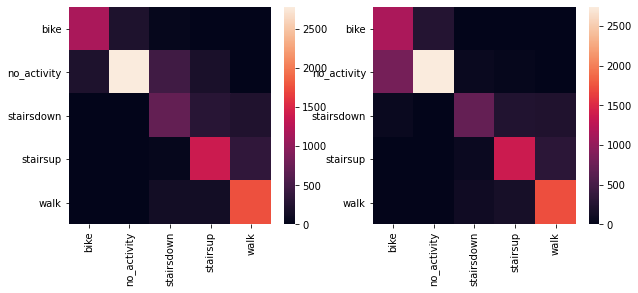

In [164]:
def build_nn(code_size):
    inputs = tf.keras.Input((code_size,))
    X = inputs
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(num_classes, activation="softmax")(X)
    outputs = X

    return tf.keras.Model(inputs=inputs, outputs=outputs)


def test_best_model(best_filename, code_size):
    
    def run_nn(codes_train, codes_test):
        nn_model = build_nn(code_size)

        adam_optimizer = tf.keras.optimizers.Adam()
        loss_funct = tf.keras.losses.CategoricalCrossentropy()

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        callbacks = [early_stopping_callback]

        nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])

        history = nn_model.fit(x=codes_train, y=y_train_hot,
            epochs=100,
            validation_data=(codes_test, y_test_hot), 
            batch_size=128,
            callbacks=callbacks,
            verbose=0)

        loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

        print(f"nn loss = {loss}")
        print(f"nn accuracy = {accuracy}")
        
        return nn_model
    

    def run_knn(codes_train, codes_test):
        from sklearn.neighbors import KNeighborsClassifier

        # create the k-neighbors calssifier
        n_neighbors = num_classes
        metric = "euclidean"

        nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

        # fit the model using the codes
        nbrs.fit(codes_train, y_train)

        from sklearn.metrics import mean_squared_error
        from sklearn.metrics import accuracy_score

        y_true = y_test
        y_pred = nbrs.predict(codes_test)

        #loss = mean_squared_error(y_true=y_true, y_pred=y_pred)
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
        print(f"knn accuracy = {accuracy}")

        return nbrs


    from sklearn import preprocessing
    from sklearn import metrics
    import seaborn as sns

    encoder = tf.keras.models.load_model(best_filename, compile=False)
    encoder.compile(optimizer="adam", loss="mse")

    codes_train = encoder.predict(X_train, verbose=0)
    codes_test = encoder.predict(X_test, verbose=0)

    nn_model = run_nn(codes_train, codes_test)
    knn_model = run_knn(codes_train, codes_test)

    le = preprocessing.LabelEncoder().fit(y_test)

    ### *** plot

    plt.figure(figsize=(10,4))
    
    # get prediction for nn

    y_true = preprocessing.LabelEncoder().fit_transform(y_test)
    y_pred = np.argmax(nn_model.predict(codes_test), axis=1)

    print(y_true)
    print(y_pred)
    
    plt.subplot(1, 2, 1)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_matrix, xticklabels=le.classes_, yticklabels=le.classes_)

    # get prediction for knn

    plt.subplot(1, 2, 2)

    y_true = preprocessing.LabelEncoder().fit_transform(y_test)
    y_pred = preprocessing.LabelEncoder().fit_transform(knn_model.predict(codes_test))

    print(y_true)
    print(y_pred)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_matrix, xticklabels=le.classes_, yticklabels=le.classes_)

    plt.show()

test_best_model("./models/encoder_cs-24_loss-mse_bs-128.h5", 24)